In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.2-bin-hadoop2.7/
spark-3.0.2-bin-hadoop2.7/R/
spark-3.0.2-bin-hadoop2.7/R/lib/
spark-3.0.2-bin-hadoop2.7/R/lib/sparkr.zip
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/worker.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/daemon.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/testthat/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/shell.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/general.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/index.html
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/R/
spark-3.0.2-

# Data Exploration and Visualization

In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt


spark = SparkSession.builder.getOrCreate()

In [3]:
spark.read.csv("Customer.csv", header=True).createOrReplaceTempView("customers")
spark.read.csv("DetailTransaction.csv", header=True).createOrReplaceTempView("detail_transactions")
spark.read.csv("HeaderTransaction.csv", header=True).createOrReplaceTempView("header_transactions")
spark.read.csv("Jacket.csv", header=True).createOrReplaceTempView("jackets")
spark.read.csv("JacketType.csv", header=True).createOrReplaceTempView("jackettypes")
spark.read.csv("Staff.csv", header=True).createOrReplaceTempView("staffs")

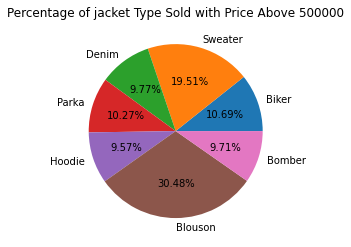

In [20]:
# a.	Show the percentage of weapon type sold for weapon type that is sold in 2019 using pie plot.
import matplotlib.pyplot as plt
data = spark.sql("""
  SELECT jt.jackettypename, SUM(td.quantity) as count
  FROM jackettypes jt JOIN jackets j
  on jt.jackettypeid = j.jackettypeid JOIN detail_transactions td
  on td.jacketid = j.jacketid
  WHERE price > 500000
  group by jt.jackettypename

""").toPandas()

plt.pie(data["count"], labels=data["jackettypename"], autopct="%.2f%%")
plt.title("Percentage of jacket Type Sold with Price Above 500000")
plt.show()

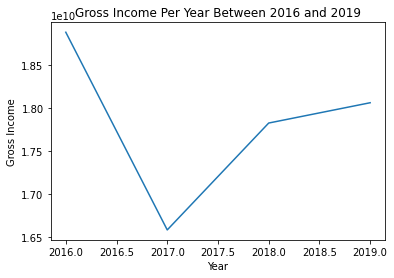

In [19]:
# b.	Show the number of gross income per year between 2016 
# until 2019 using line plot.
#distinct untuk multiple transaction yg id sama hitung 1

#.show()
import matplotlib.pyplot as plt
data = spark.sql("""
  SELECT SUM(td.quantity * j.price) as income, YEAR(th.transactiondate) as Year
  FROM header_transactions th JOIN detail_transactions td
  on td.transactionid = th.transactionid JOIN Jackets j 
  on j.jacketid = td.jacketid JOIN jackettypes jt
  on j.jackettypeid = jt.jackettypeid
  WHERE year(th.transactiondate) between 2016 and 2019 
  group by YEAR(th.transactiondate)
  order by YEAR(th.transactiondate)

""").toPandas()

plt.plot(data["Year"], data["income"])
plt.xlabel("Year")
plt.ylabel("Gross Income")
plt.title("Gross Income Per Year Between 2016 and 2019")
plt.show()

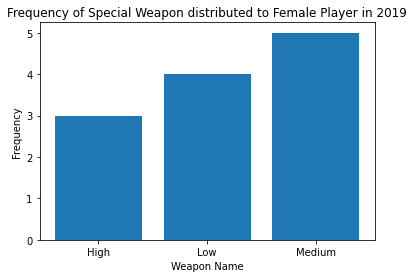

In [34]:
# c.	Show the frequency of the order rate for every month in 2019 using bar plot. The order rate in a certain month is determined based on the following condition: 
# Order Rate	Jackets Ordered per Month
# High	> 4000
# Medium	2501 - 4000
# Low	<= 2500

import matplotlib.pyplot as plt
data = spark.sql("""
select rate, count(*) as count
  from (
  SELECT SUM(td.Quantity) as ordered, MONTH(th.transactiondate),
    case
      when SUM(td.Quantity) > 4000 then 'High'
      when SUM(td.Quantity) between 2500 and 4001 then 'Medium'
      when SUM(td.Quantity) <= 2500 then 'Low'
    end as rate
  FROM detail_transactions td JOIN header_transactions th on td.transactionid = th.transactionid 
  WHERE year(th.transactiondate) = 2019
  group by MONTH(th.transactiondate)
) 
group by rate
""").toPandas()

plt.bar(data["rate"], data["count"])
plt.xlabel("Weapon Name")
plt.ylabel("Frequency")
plt.title("Frequency of Special Weapon distributed to Female Player in 2019")
plt.show()

# Data Clustering

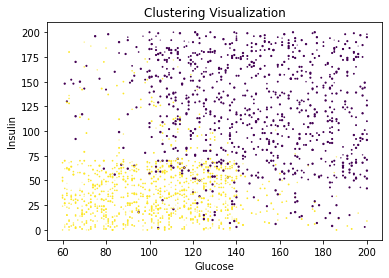

Accuracy: 91.01479915433404%


In [39]:
testing = spark.read.csv("Test.csv", header=True, inferSchema=True)
training = spark.read.csv("Train.csv", header=True, inferSchema=True)

columns = ["Glucose", "Insulin", "DiabetesPedigreeFunction"]

testing = testing.na.drop()
training = training.na.drop()

testing = testing.select("Glucose", "Insulin", "DiabetesPedigreeFunction", "Outcome")
training = training.select(columns)

from pyspark.sql.functions import when
#otherwise(2) = .when yg paling akhir


testing = testing.withColumn(
    "Outcome",
    when (testing ["Outcome"]=="No", 1)
    .otherwise(0)
)


from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols=columns, outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")

testing = assembler.transform(testing)
training = assembler.transform(training)

testing = scaler.fit(testing).transform(testing)
training = scaler.fit(training).transform(training)

from pyspark.ml.clustering import KMeans

#seed=1 tambahan
kmeans = KMeans(k=2)
model = kmeans.fit(training)
data = model.transform(testing)
data = data.toPandas()

plt.scatter(
    data["Glucose"],
    data["Insulin"],
    data["DiabetesPedigreeFunction"],
    c=data["prediction"]
)

plt.title("Clustering Visualization")
plt.xlabel("Glucose")
plt.ylabel("Insulin")
plt.show()

c = 0
for idx, row in data.iterrows():
   if row["Outcome"] == row["prediction"]: c += 1

acc = c /len(data) * 100
print(f'Accuracy: {acc}%')

